In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install fastseg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.5 MB/s eta 0:00:00


In [3]:
from fastai.vision.all import *

import os
import matplotlib.pyplot as plt
import cv2
import albumentations  as albu
albu.__version__

'1.3.1'

In [4]:

def get_image_array_from_fn(fn):
    image = cv2.imread(fn)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [5]:
DATA_DIR = "/content/drive/MyDrive/fastai_dataset"

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_label')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_label')

In [6]:
# function that takes filename of a training image 'fn' and returns the filename of the corresponding label image
def label_func(fn):
    return str(fn).replace(".png", "_label.png").replace("train", "train_label").replace("val/", "val_label/")

/content/drive/MyDrive/fastai_dataset/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2925.png


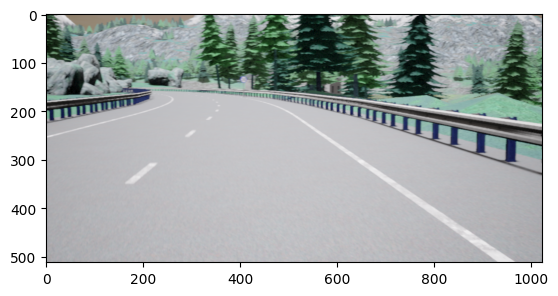

In [7]:
# pick the first image from the training directory and show it
sample_fn = x_train_dir + "/" + os.listdir(x_train_dir)[0]
print(sample_fn)
plt.imshow(get_image_array_from_fn(sample_fn));

/content/drive/MyDrive/fastai_dataset/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2925_label.png


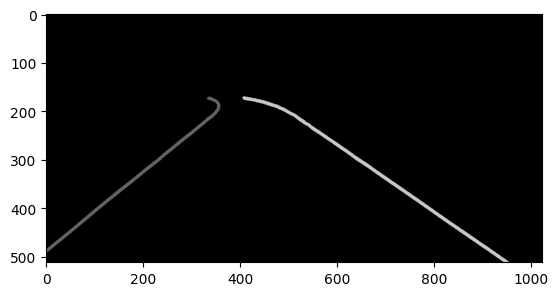

In [8]:
# get corresponding label image using our 'label_func' function
label_fn = label_func(sample_fn)
print(label_fn)
# we multiply the image intensity by 100 to make lane lines visible for the human eye:
plt.imshow(100*get_image_array_from_fn(label_fn));

In [9]:
my_get_image_files = partial(get_image_files, folders=["train", "val"])

In [10]:
# Let's do some data augmentation!
# We define a wrapper class to integrate albumentations library with fastai
# Read https://docs.fast.ai/tutorial.albumentations.html for details
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])


albu_transform_list = [
    albu.IAAAdditiveGaussianNoise(p=0.2),
    albu.OneOf(
        [
            albu.CLAHE(p=1),
            albu.RandomBrightness(p=1),
            albu.RandomGamma(p=1),
        ],
        p=0.6,
    ),
    albu.OneOf(
        [
            albu.IAASharpen(p=1),
            albu.Blur(blur_limit=3, p=1),
            albu.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.6,
    ),
    albu.OneOf(
        [
            albu.RandomContrast(p=1),
            albu.HueSaturationValue(p=1),
        ],
        p=0.6,
    ),
]
albu_transform = albu.Compose(albu_transform_list)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [11]:
codes = np.array(['back', 'left','right'],dtype=str)
carla = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = my_get_image_files,
                   get_y = label_func,
                   splitter = FuncSplitter(lambda x: str(x).find('validation_set')!=-1),
                   item_tfms=[SegmentationAlbumentationsTransform(albu_transform)])
dls = carla.dataloaders(Path(DATA_DIR), path=Path("."), bs=2)

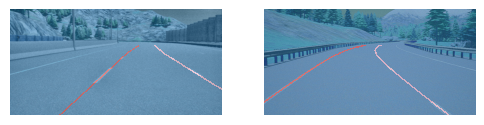

In [12]:
dls.show_batch(max_n=6)

In [13]:
from fastseg import MobileV3Small

model = MobileV3Small(num_classes=3, use_aspp=True, num_filters=8)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_100-37f49e2b.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_100-37f49e2b.pth


In [31]:
learn = Learner(dls, model, metrics=[Dice()])
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.009198,0.010261,1.401872,04:09


epoch,train_loss,valid_loss,dice,time
0,0.007053,0.007407,1.470439,04:10
1,0.006818,0.006483,1.499644,04:08
2,0.006171,0.005860,1.508975,04:09
3,0.005270,0.005528,1.520965,04:09
4,0.005159,0.005192,1.530270,04:09


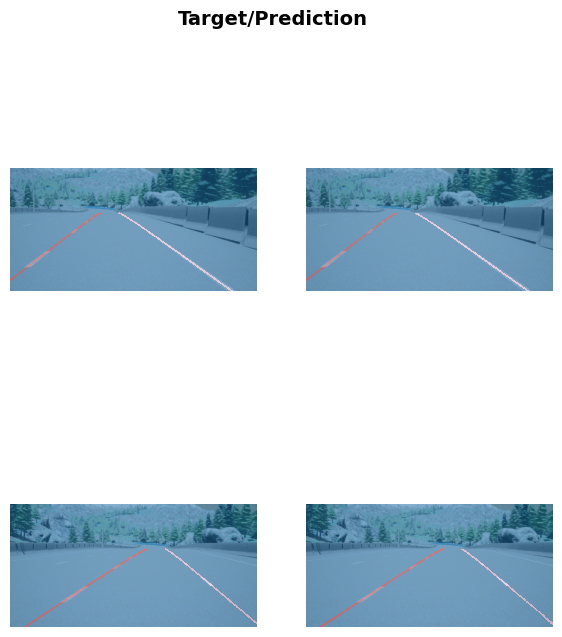

In [32]:
learn.show_results(max_n=6, figsize=(7,8))

In [33]:
torch.save(learn.model, '/content/drive/MyDrive/fastai_dataset/fastai_model_dice.pth')

In [34]:
import cv2
img = cv2.imread(str(get_image_files(x_valid_dir)[3]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

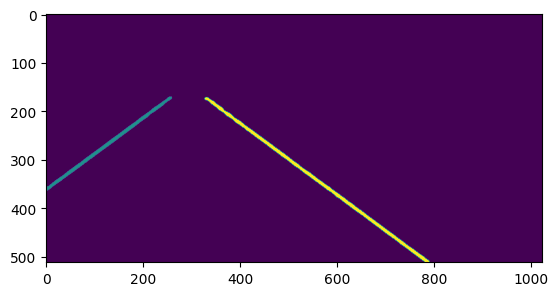

In [35]:
plt.imshow(np.array(learn.predict(img)[0]))


In [36]:
def get_pred_for_mobilenet(model, img_array):
    with torch.no_grad():
        image_tensor = img_array.transpose(2,0,1).astype('float32')/255
        x_tensor = torch.from_numpy(image_tensor).to("cuda").unsqueeze(0)
        model_output = F.softmax( model.forward(x_tensor), dim=1 ).cpu().numpy()
    return model_output

In [37]:
learn.model.eval();

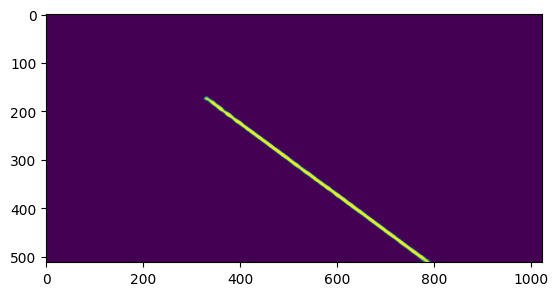

In [41]:
plt.imshow(get_pred_for_mobilenet(learn.model,img)[0][2])


In [42]:
%timeit get_pred_for_mobilenet(learn.model,img)

17.2 ms ± 552 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


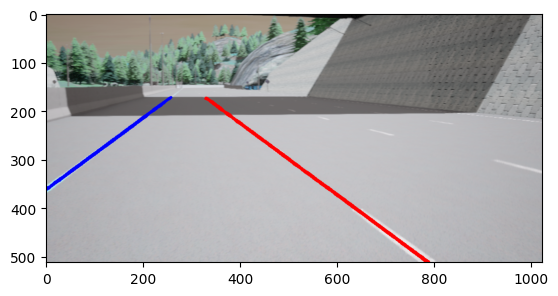

In [43]:
import copy
back, left, right = get_pred_for_mobilenet(learn.model,img)[0]
def ld_detection_overlay(image, left_mask, right_mask):
    res = copy.copy(image)
    res[left_mask > 0.3, :] = [0,0,255]
    res[right_mask > 0.3, :] = [255,0,0]
    return res
plt.imshow(ld_detection_overlay(img, left, right))